# Data Volume Analysis for Cascadia Project

This notebook analyzes the volume of data in the Cascadia project, including:
- Actual file sizes on disk
- Theoretical waveform data volume
- Data distribution across different file types
- Visualization of data volumes

By Marine Denolle (mdenolle@uw.edu)

In [11]:
# Import required libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from obspy.clients.fdsn import Client
import h5py

In [17]:
def calculate_station_days(start_date, end_date, min_lat, max_lat, min_lon, max_lon):
    """
    Calculate total station-days within specified bounds using direct station search
    
    Parameters:
    -----------
    start_date : datetime
        Start date for analysis
    end_date : datetime
        End date for analysis
    min_lat : float
        Minimum latitude
    max_lat : float
        Maximum latitude
    min_lon : float
        Minimum longitude
    max_lon : float
        Maximum longitude
    
    Returns:
    --------
    dict
        Statistics about station availability
    """
    client = Client("IRIS")
    total_days = 0
    available_stations = []
    station_details = []
    
    # Get all stations in the region directly
    try:
        inventory = client.get_stations(
            starttime=start_date,
            endtime=end_date,
            minlatitude=min_lat,
            maxlatitude=max_lat,
            minlongitude=min_lon,
            maxlongitude=max_lon,
            level="channel",
            channel="BH?,HH?,EH?",
            includeavailability=True
        )
        
        # Process each network
        for network in inventory:
            for station in network:
                try:
                    # Calculate station operation days
                    sta_start = max(start_date, station.start_date.datetime)
                    sta_end = min(end_date, station.end_date.datetime if station.end_date else end_date)
                    
                    days = (sta_end - sta_start).days
                    if days > 0:
                        total_days += days
                        station_id = f"{network.code}.{station.code}"
                        available_stations.append(station_id)
                        
                        # Get channel availability
                        channels = [ch.code for ch in station.channels]
                        
                        station_details.append({
                            'network': network.code,
                            'station': station.code,
                            'latitude': station.latitude,
                            'longitude': station.longitude,
                            'elevation': station.elevation,
                            'start_date': sta_start,
                            'end_date': sta_end,
                            'days': days,
                            'channels': ','.join(channels)
                        })
                        
                except Exception as e:
                    print(f"Error processing station {network.code}.{station.code}: {e}")
                    continue
                    
    except Exception as e:
        print(f"Error querying stations: {e}")
        return None
    
    # Create DataFrame with station details
    station_df = pd.DataFrame(station_details)
    
    # Calculate statistics
    stats = {
        'total_station_days': total_days,
        'unique_stations': len(available_stations),
        'average_days_per_station': total_days / len(available_stations) if available_stations else 0,
        'station_details': station_df
    }
    
    return stats

# Example usage remains the same, but remove networks_stas parameter
analysis_bounds = {
    'start_date': datetime(2010, 1, 1),
    'end_date': datetime(2015, 12, 31),
    'min_lat': 40.0,
    'max_lat': 50.0,
    'min_lon': -129.0,
    'max_lon': -122.0
}

# Calculate station days
stats = calculate_station_days(**analysis_bounds)

In [18]:
stats

{'total_station_days': 708488,
 'unique_stations': 842,
 'average_days_per_station': 841.4346793349168,
 'station_details':     network station   latitude   longitude  elevation start_date  \
 0        3F   FLM45  44.214802 -122.254501      468.2 2010-05-18   
 1        3F   FLM66  44.214500 -122.254402      458.1 2010-05-18   
 2        5E   CM01A  40.722698 -123.985397      708.0 2014-10-04   
 3        5E   CM02A  40.660801 -124.168800      122.0 2014-10-04   
 4        5E   CM03A  40.602798 -123.959099      582.0 2014-10-04   
 ..      ...     ...        ...         ...        ...        ...   
 837      ZZ    CW11  47.029099 -123.296700      113.0 2012-06-05   
 838      ZZ    CW12  47.010601 -123.164597      415.0 2012-06-05   
 839      ZZ    CW13  47.040100 -123.026604      173.0 2012-06-05   
 840      ZZ    CW14  46.839401 -122.731201      160.0 2012-06-05   
 841      ZZ    CW15  46.866798 -122.380600      192.0 2012-06-05   
 
                end_date  days     channels  
 

In [19]:
# the list of network codes analyzed
#  \texttt{C8}, \texttt{7D}, \texttt{7A}, \texttt{CN}, \texttt{NV}, \texttt{UW}, \texttt{UO}, \texttt{NC}, \texttt{BK}, \texttt{TA}, \texttt{OO}, \texttt{PB}, \texttt{X6}, \texttt{Z5}, and \texttt{X9}.
network_codes = ['C8', '7D', '7A', 'CN', 'NV', 'UW', 'UO', 'NC', 'BK', 'TA', 'OO', 'PB', 'X6', 'Z5', 'X9']

In [20]:
# from stats exctract the total number of station-days for the specific network codes
total_station_days = 0
for net_code in network_codes:
    net_stations = stats['station_details'][stats['station_details']['network'] == net_code]
    total_station_days += net_stations['days'].sum()
total_station_days

582936

In [22]:
# estimate how much data volume this fits for 100 Hz data with 3 channels (BH?, HH?, EH?)
sampling_rate = 100  # samples per second
num_channels = 3
bytes_per_sample = 4  # assuming 32-bit float
total_seconds = total_station_days * 24 * 3600
total_data_volume_bytes = total_seconds * sampling_rate * num_channels * bytes_per_sample
total_data_volume_gb = total_data_volume_bytes / (1024**3)
print(total_data_volume_gb)

56288.02299499512


stats

In [3]:
# Function to calculate theoretical waveform data volume
def calculate_theoretical_volume():
    """Calculate theoretical volume of waveform data based on metadata."""
    try:
        # Read the arrival data
        data_dir = os.path.join(os.path.dirname(os.getcwd()), 'data')
        df = pd.read_csv(os.path.join(data_dir, 'arrival_2010_2015_reloc_cog_ver3.csv'))
        
        # Calculate parameters
        unique_events = df['time'].nunique()
        sampling_rate = 100  # Hz
        duration = 63  # seconds (3s pre + 60s post arrival)
        channels = 3  # assuming 3 components
        bytes_per_sample = 4  # assuming 32-bit float
        
        # Calculate total theoretical size
        theoretical_size = (
            unique_events *  # number of events
            sampling_rate *  # samples per second
            duration *      # seconds per trace
            channels *      # components per station
            bytes_per_sample  # bytes per sample
        )
        
        return {
            'unique_events': unique_events,
            'theoretical_size': theoretical_size,
            'parameters': {
                'sampling_rate': sampling_rate,
                'duration': duration,
                'channels': channels,
                'bytes_per_sample': bytes_per_sample
            }
        }
    
    except Exception as e:
        print(f"Error calculating theoretical volume: {e}")
        return None

In [4]:
# Calculate actual file sizes
file_sizes, file_counts = calculate_file_sizes()

# Print summary of actual files
print("\nFile Count Summary:")
for ext, count in file_counts.items():
    print(f"{ext.upper()} files: {count}")

print("\nFile Size Summary:")
for ext, size in file_sizes.items():
    print(f"{ext.upper()} files: {size/1024/1024:.2f} MB")

total_size = sum(file_sizes.values())
print(f"\nTotal size of all files: {total_size/1024/1024:.2f} MB")

Scanning directory: /Users/marinedenolle/GitHub/cascadia_obs_ensemble/data
Found CSV file: vel_pnsn_jdf.csv, Size: 0.00 MB
Found CSV file: vel_or_shelf_trench.csv, Size: 0.00 MB
Found CSV file: nodes_nwa_shelf_trench.csv, Size: 0.00 MB
Found CSV file: nodes_pnsn_jdf.csv, Size: 0.00 MB
Found CSV file: nodes_pnsn_sor.csv, Size: 0.00 MB
Found CSV file: vel_or_shore.csv, Size: 0.00 MB
Found CSV file: vel_pnsn_nor.csv, Size: 0.00 MB
Found CSV file: nodes_swa_shore.csv, Size: 0.00 MB
Found CSV file: jgrb52524-sup-0003-2017jb014966-ds02.csv, Size: 0.02 MB
Found CSV file: nodes_pnsn_nor.csv, Size: 0.00 MB
Found CSV file: nodes_or_shore.csv, Size: 0.00 MB
Found CSV file: nodes_or_shelf_trench.csv, Size: 0.00 MB
Found CSV file: vel_nwa_shore.csv, Size: 0.00 MB
Found CSV file: vel_nwa_shelf_trench.csv, Size: 0.00 MB
Found CSV file: vel_pnsn_sor.csv, Size: 0.00 MB
Found CSV file: ds01.csv, Size: 0.55 MB
Found CSV file: jgrb52524-sup-0004-2017jb014966-ds03.csv, Size: 0.00 MB
Found XLSX file: ds03.x

In [5]:
# Calculate theoretical volume
theory_results = calculate_theoretical_volume()

if theory_results:
    print("\nTheoretical Waveform Data Analysis:")
    print(f"Number of unique events: {theory_results['unique_events']}")
    print(f"Theoretical data volume: {theory_results['theoretical_size']/1024/1024:.2f} MB")
    print("\nParameters used:")
    for param, value in theory_results['parameters'].items():
        print(f"{param}: {value}")

Error calculating theoretical volume: [Errno 2] No such file or directory: '/Users/marinedenolle/GitHub/cascadia_obs_ensemble/data/arrival_2010_2015_reloc_cog_ver3.csv'


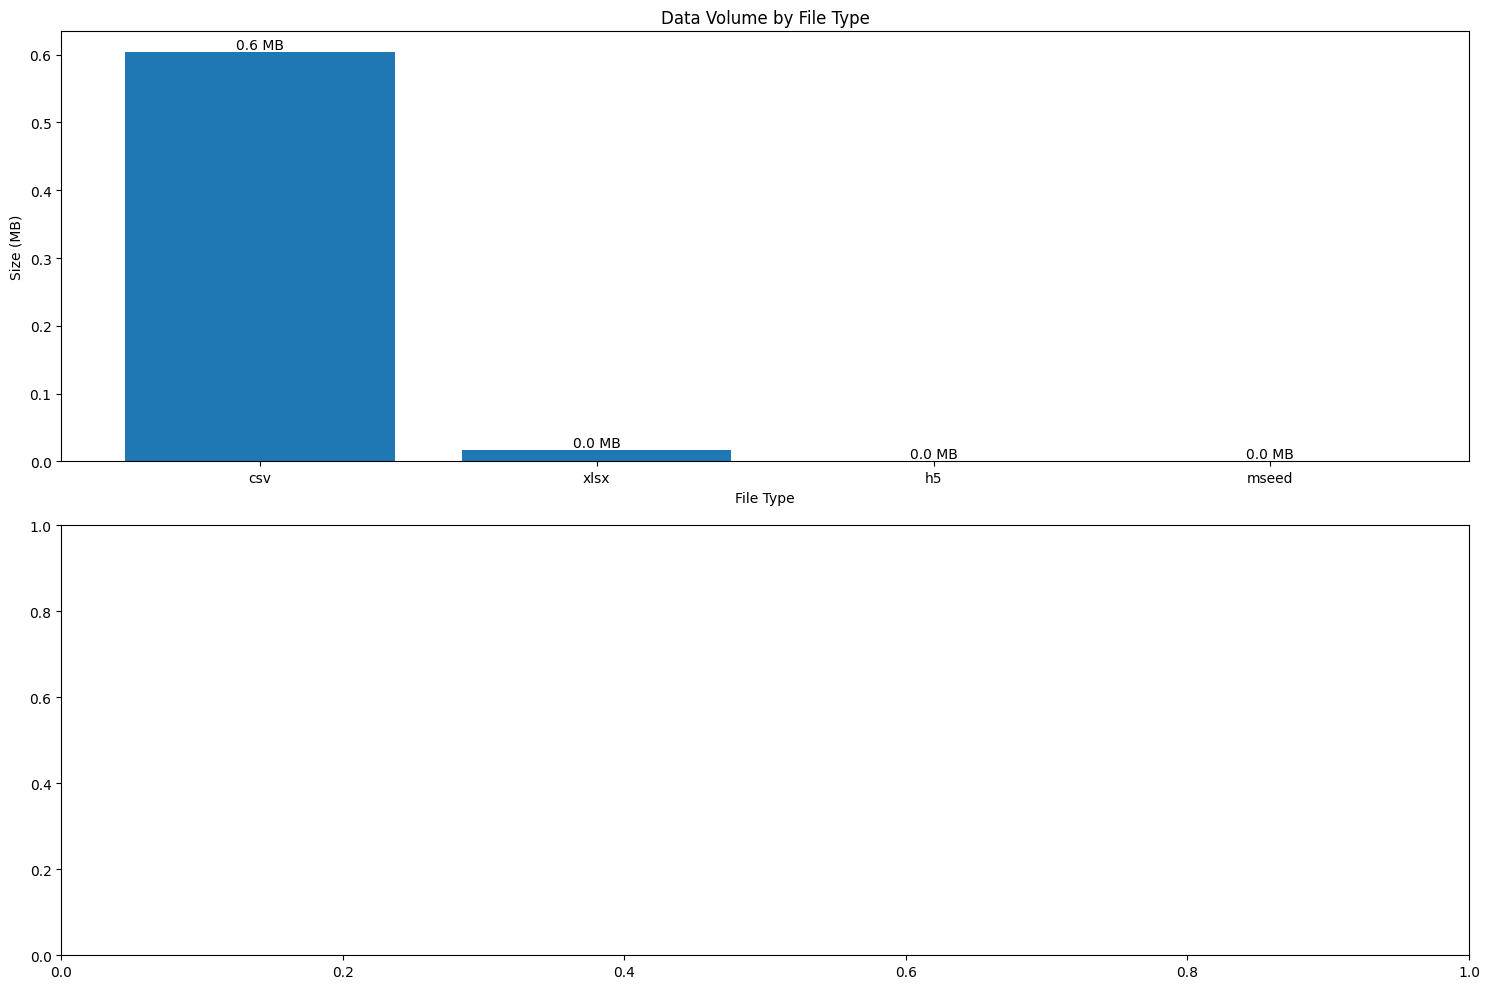

In [6]:
# Create visualizations of data volumes
plt.figure(figsize=(15, 10))

# Create subplot for file type distribution
plt.subplot(2, 1, 1)
extensions = list(file_sizes.keys())
sizes = [size/1024/1024 for size in file_sizes.values()]  # Convert to MB
plt.bar(extensions, sizes)
plt.title('Data Volume by File Type')
plt.xlabel('File Type')
plt.ylabel('Size (MB)')

# Add value labels on top of bars
for i, size in enumerate(sizes):
    plt.text(i, size, f'{size:.1f} MB', ha='center', va='bottom')

# Create subplot for actual vs theoretical volume
plt.subplot(2, 1, 2)
if theory_results:
    volumes = [
        total_size/1024/1024,
        theory_results['theoretical_size']/1024/1024
    ]
    labels = ['Actual Files', 'Theoretical Waveforms']
    plt.bar(labels, volumes)
    plt.title('Actual vs Theoretical Data Volume')
    plt.ylabel('Size (MB)')
    plt.yscale('log')  # Use log scale if values are very different
    
    # Add value labels on top of bars
    for i, volume in enumerate(volumes):
        plt.text(i, volume, f'{volume:.1f} MB', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Summary and Documentation

This notebook has analyzed the data volume in the Cascadia project by:
1. Calculating actual file sizes for different file types (CSV, XLSX, H5, MSEED)
2. Estimating theoretical waveform data volume based on:
   - Number of unique events
   - Sampling rate (100 Hz)
   - Duration per trace (63 seconds)
   - Number of components (3)
   - Data precision (32-bit float)
3. Visualizing the distribution of data across file types
4. Comparing actual vs theoretical data volumes

This information is useful for:
- Storage planning
- Data transfer estimates
- Resource allocation
- Project documentation